# Climate Analysis

>### Prepare SQLite Session

In [2]:
#Import dependencies

#Enigine/Session
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#Data visualization
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

#Formatting
import datetime
import numpy as np

In [3]:
#Create engine
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [4]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [5]:
# Map Station class
Stations = Base.classes.stations

# Map Measurement class
Measures = Base.classes.measurements

# create a session
session = Session(engine)

>###   Precipitation Analysis

In [6]:
#Find last record (most recent date) in data
last_record = session.query(Measures.date).order_by(Measures.date.desc()).first()
print(last_record)
type(last_record)

('2017-08-23',)


sqlalchemy.util._collections.result

In [7]:
#Datetime doesn't like a "result", do something to make it a string and clean it up
date = str(last_record).split("'")[1]
print(date)
type(date)

2017-08-23


str

In [8]:
#Determine one year (12 months) from last record
last_date = datetime.datetime.strptime(date, "%Y-%m-%d")
last = last_date - datetime.timedelta(days=364)
last_year = last.strftime("%Y-%m-%d")
print(last_year)

2016-08-24


In [9]:
#Query one year of precipitation data from SQLite database
data = session.query(Measures.date, Measures.prcp).\
    filter(Measures.date >= last_year).all()

In [10]:
#Don't understand session.statement parameters to make a query into a DataFrame?  
#Iterating into lists will get you there too.  
plot_date = []
plot_prcp = []
for x in data:
    plot_date.append(str(x).split("'")[1])
    plot_prcp.append(float(str(x).split(",")[1].split(")")[0]))

In [11]:
#Build DataFrame, sort so that final plot will be in sequential date order
prcp_data = {
    "Date":plot_date,
    "Precipitation":plot_prcp
}

prcp_df = pd.DataFrame(data=prcp_data)
prcp_df = prcp_df.sort_values(by=["Date"])
prcp_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1024,2016-08-24,1.22
700,2016-08-24,2.28
1688,2016-08-24,1.45
358,2016-08-24,2.15


In [12]:
#Project parameters did not specify details other than to view precipitation vs. date.  
#I chose to group by date to reduce data set from 2000+ entries and to show only max prcp
#result from any station that date.  This story seemed most helpful to me for vacation 
#planning (what's the worst to pack for?).

date_df = prcp_df.groupby(prcp_df["Date"]).max()
date_df.head()

,Precipitation
Date,
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07


<IPython.core.display.Javascript object>


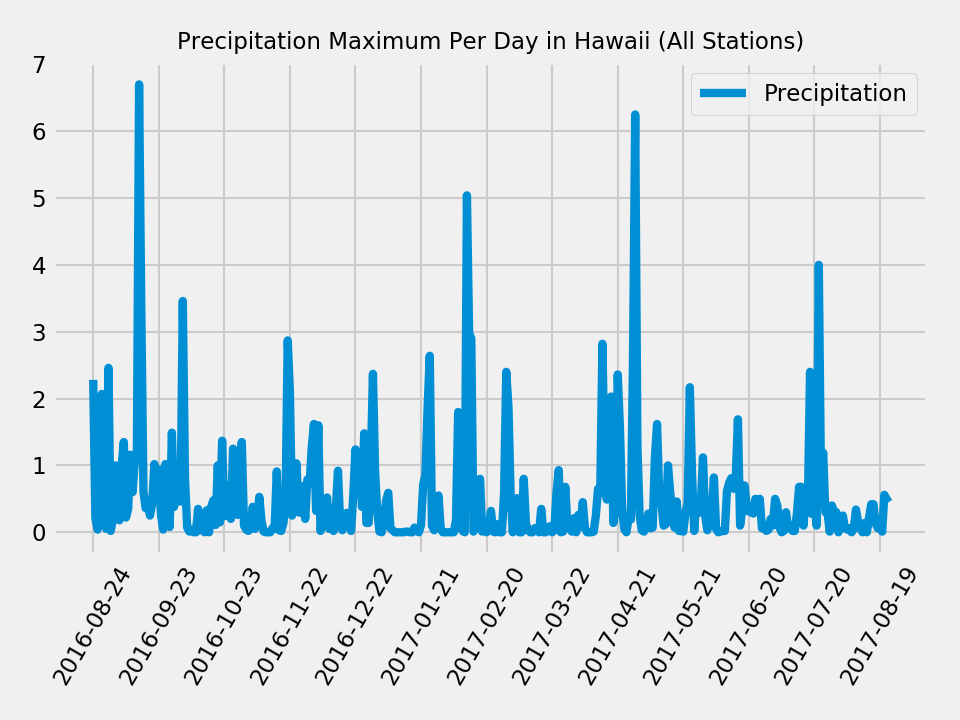

In [13]:
#Plot parameters
x_axis = np.arange(len(date_df))  
labels = date_df.index[0::30]
#Plot data
fig = date_df.plot(x=x_axis,xticks=x_axis[0::30],fontsize=11)
plt.title("Precipitation Maximum Per Day in Hawaii (All Stations)", fontsize = 11)
plt.legend(loc = 1, fontsize = 11)
fig.set_xticklabels(labels, rotation=60)
#Tightened plot up to view full labels
plt.tight_layout()
plt.show()

In [14]:
#Statistical summary for all stations (last 12 months)
summary = prcp_df["Precipitation"].describe()
print(summary)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


In [15]:
#Statistical summary of maximum prcp reading from each station (last 12 months)
summary_date = date_df["Precipitation"].describe()
print(summary_date)

count    365.000000
mean       0.517288
std        0.829196
min        0.000000
25%        0.040000
50%        0.250000
75%        0.650000
max        6.700000
Name: Precipitation, dtype: float64


In [16]:
#A few more meaning pieces of data
y = date_df["Precipitation"].max()
y_date = date_df.loc[date_df["Precipitation"]==y].index
y_date = str(y_date).split("'")[1]
total = prcp_df["Precipitation"].sum()

In [17]:
#Written summary
print(f"From {str(int(summary[0]))} measurements gathered across all weather stations in the past \
{int(summary_date[0])} days...\nHawaii recieved {round(total,2)} inches of total precipitation.\nThe \
maximum precipitation at a single weather station on any day was {round(summary[7],2)} inches on {y_date}.\nThe average daily \
precipitation was {round(total/summary_date[0],2)} inches.")

From 2015 measurements gathered across all weather stations in the past 365 days...
Hawaii recieved 355.57 inches of total precipitation.
The maximum precipitation at a single weather station on any day was 6.7 inches on 2016-09-14.
The average daily precipitation was 0.97 inches.


>### Station Analysis

In [18]:
#Determine how many weather stations
session.query(Measures.station).distinct().count()

9

In [19]:
#Determine most active weather stations by SQLite query
active = session.query(Measures.station, func.count(Measures.prcp)).\
group_by(Measures.station).\
order_by(func.count(Measures.prcp).desc()).all()
for x in active:
    print(x)

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [20]:
#Most active weather station
most_active = str(active[0]).split("'")[1]
session.query(Stations.station, Stations.name).filter(Stations.station == most_active).all()

[('USC00519281', 'WAIHEE 837.5, HI US')]

In [21]:
#Query one year of 'tobs' data from the most active weather station in SQLite database
data2 = session.query(Measures.date, Measures.tobs).\
    filter(Measures.date >= last_year).\
    filter(Measures.station == most_active).all()

In [22]:
#Collect data from query to plot
plot_date = []
plot_tobs = []
for x in data2:
    plot_date.append(str(x).split("'")[1])
    plot_tobs.append(float(str(x).split(",")[1].split(")")[0]))
print(plot_date[-1])
print(plot_tobs[-1])

2017-08-18
79.0


<IPython.core.display.Javascript object>


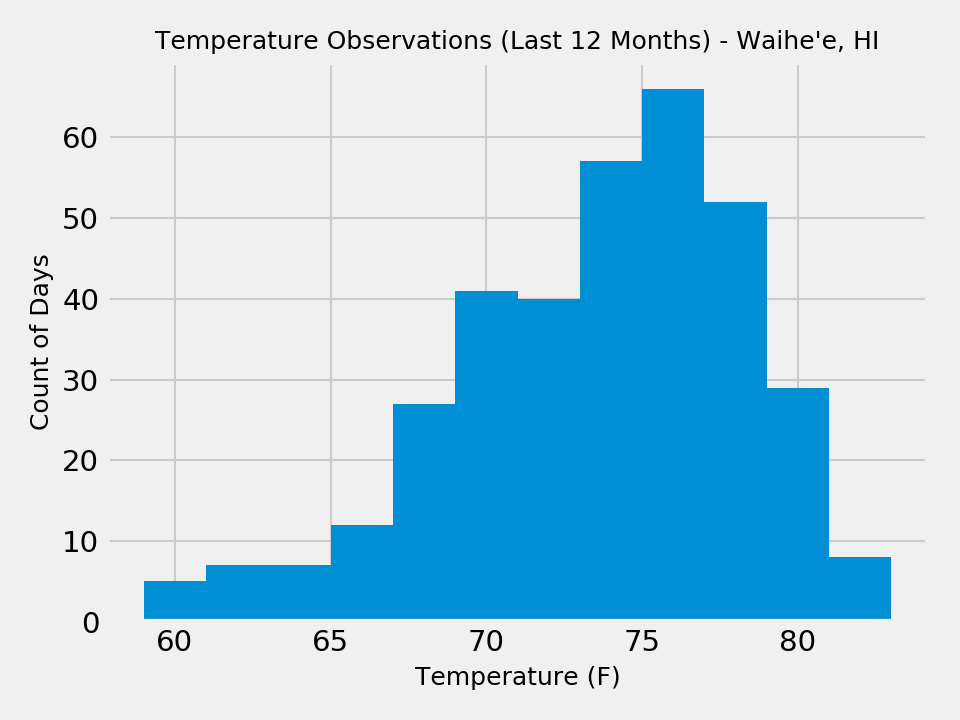

In [23]:
#Plot data in histogram
plt.hist(plot_tobs, bins=12)
plt.title("Temperature Observations (Last 12 Months) - Waihe'e, HI",fontsize = 12)
plt.xlabel("Temperature (F)",fontsize = 12)
plt.ylabel("Count of Days", fontsize = 12)
plt.tight_layout()
plt.show()

>### Temperature Analysis

In [24]:
# Define a function called 'calc_temps' that will accept user inputs of 'start date' 
# and 'length of trip' and return the minimum, average, and maximum temperatures 
# for that range of dates last year.

#Keep 'global' for later user

def calc_temps(x,y):
    
    #Split user input string into variables
    global user_month
    user_month = user_date.split("/")[0]
    global user_day
    user_day = user_date.split("/")[1]
    user_year = user_date.split("/")[2]
    user_all = "20"+user_year+"-"+user_month+"-"+user_day
    #Parse varibles into datetime object
    start = datetime.datetime.strptime(user_all, "%Y-%m-%d")
    #Set start date as same date last year
    start_date = (start - datetime.timedelta(days=365))
    #Calculate for end date based on trip length
    end_date = (start_date + datetime.timedelta(days=trip_len))
    #Format result for hawaii sqlite query
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    #Set parameters to return avg, min, and max temps from SQLite query
    sel = [Measures.date, 
       func.avg(Measures.tobs), 
       func.max(Measures.tobs), 
       func.min(Measures.tobs),]
    
    #Query database for data during trip dates
    trip_averages = session.query(*sel).\
    filter(func.strftime(Measures.date) >= start_date).\
    filter(func.strftime(Measures.date) <= end_date).all()
    
    #Print query
    print(f"Last year the average temperature for these dates was {round(trip_averages[0][1])}(F),\n\
with the warmest temperature being {round(trip_averages[0][2])}(F) and the coolest being \
{round(trip_averages[0][3])}(F).")
    
    #Store these results for plotting
    global barchart_x
    barchart_x = start_date.split("-")[1]+"-"+start_date.split("-")[2]\
    +" to "+ end_date.split("-")[1]+"-"+end_date.split("-")[2]
    global barchart_y
    barchart_y = trip_averages[0][1]
    global barchart_yerr
    barchart_yerr= trip_averages[0][2] - trip_averages[0][3]

In [25]:
user_date = input("Start date of trip (enter as mm/dd/yy): ")
trip_len = int(input("Length of trip in days: "))
calc_temps(user_date,trip_len)

Start date of trip (enter as mm/dd/yy): 07/09/18
Length of trip in days: 8
Last year the average temperature for these dates was 78(F),
with the warmest temperature being 82(F) and the coolest being 69(F).


<IPython.core.display.Javascript object>


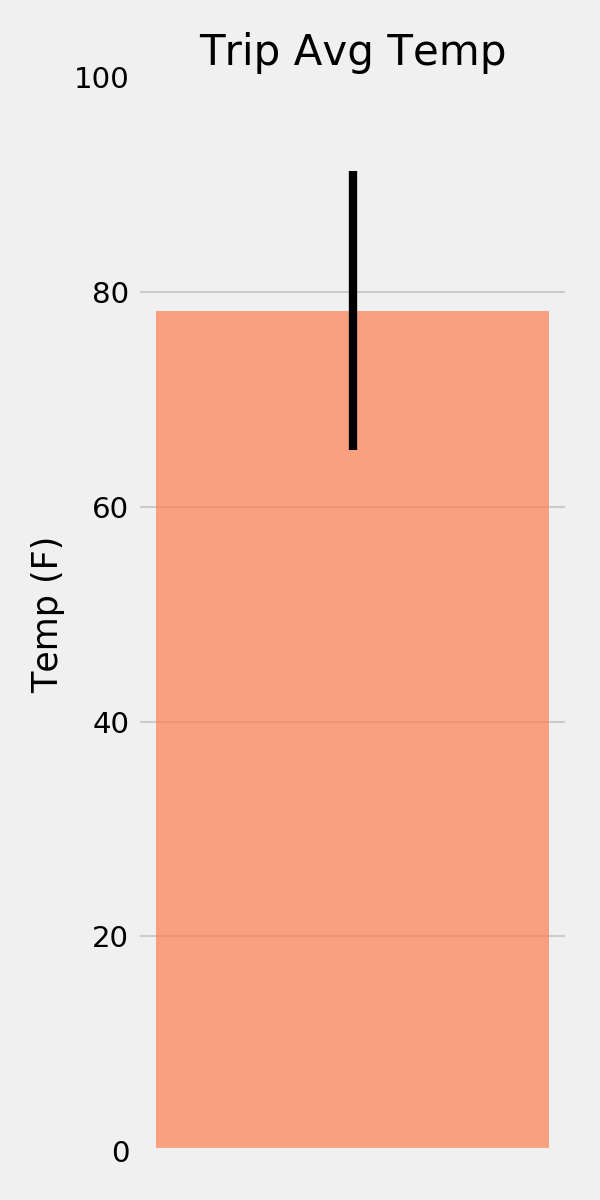

In [26]:
fig, ax = plt.subplots(figsize = plt.figaspect(2.))

ax.bar(1, barchart_y, alpha=.7, color='coral', yerr=barchart_yerr)
ax.set(title="Trip Avg Temp", ylabel = "Temp (F)", xticks = range(1), xticklabels = barchart_x, ylim = (0,100))
plt.tight_layout()
plt.show()

>## Optional Analysis

>#### Rainfall Per Weather Station

In [27]:
#Find total rainfall per station

#Query one year of precipitation data from SQLite database
data3 = session.query(Measures.station, Measures.prcp).\
    filter(Measures.date >= last_year).all()

#Store data for DataFrame
stations = []
prcps = []

for x in data3:
    stations.append(str(x).split("'")[1])
    prcps.append(float(str(x).split(",")[1].split(")")[0]))

#Build DataFrame
station_data = {
    "station": stations,
    "Precipitation (in inches)":prcps
    }

stations_df = pd.DataFrame(data=station_data)

#Get total rainfall per station (last year)
stations_df = stations_df.groupby(["station"]).sum()
stations_df

,Precipitation (in inches)
station,
USC00513117,48.36
USC00514830,33.19
USC00516128,147.11
USC00517948,4.59
USC00519281,68.24
USC00519397,16.09
USC00519523,37.99


>#### Daily Normals

In [28]:
#Plot daily normals for user input trip

#Make a list that captures all dates for query from user input trip info
user_dates = []

#Split user input string into variables
user_all = user_month+"-"+user_day
#Parse varibles into datetime object
start_date = datetime.datetime.strptime(user_all, "%m-%d")
#Iterate through trip_len, creating next datetime object
for x in range(trip_len):
    if x == 0:
        start_date = (start_date + datetime.timedelta(days=x))
        next_date = start_date.strftime("%m-%d")
        user_dates.append(next_date)
    else:
        next_date = (start_date + datetime.timedelta(days=x))
        next_date = next_date.strftime("%m-%d")
        user_dates.append(next_date)
        continue

print(user_dates)

['07-09', '07-10', '07-11', '07-12', '07-13', '07-14', '07-15', '07-16']


In [29]:
#Create a function called daily_normals that will calculate the daily normals from user input date

def daily_normals(x):
    #Format for hawaii sqlite query
    start_month = x.split("-")[0]
    start_day = x.split("-")[1]
    
    #Set parameters to return avg, min, and max temps from SQLite query
    sel = [Measures.date, 
       func.avg(Measures.tobs), 
       func.max(Measures.tobs), 
       func.min(Measures.tobs),]
    
    #Save returns in variable
    global daily_normals_return
    daily_normals_return = session.query(*sel).\
    filter(func.strftime("%m", Measures.date) == start_month).\
    filter(func.strftime("%d", Measures.date) == start_day).all()

In [30]:
#Run function based on user input, collect for entire trip and build into DataFrame
days = []
tavgs = []
tmaxs = []
tmins = []

#Iterate through list of dates
for x in user_dates:
    days.append(x)
    #Run function
    daily_normals(x)
    #Pull returned data into lists
    tavgs.append(round(daily_normals_return[0][1],2))
    tmaxs.append(daily_normals_return[0][2])
    tmins.append(daily_normals_return[0][3])

#Build DataFrame
normals_data = {
    "TAvg":tavgs,
    "TMax":tmaxs,
    "Tmin":tmins
    }

normals_df = pd.DataFrame(data=normals_data, index = days)
normals_df

,TAvg,TMax,Tmin
07-09,76.09,83.0,68.0
07-10,75.51,82.0,68.0
07-11,75.47,81.0,70.0
07-12,75.77,82.0,67.0
07-13,76.12,81.0,69.0
07-14,76.37,82.0,67.0
07-15,76.22,82.0,68.0
07-16,76.29,83.0,70.0


<IPython.core.display.Javascript object>


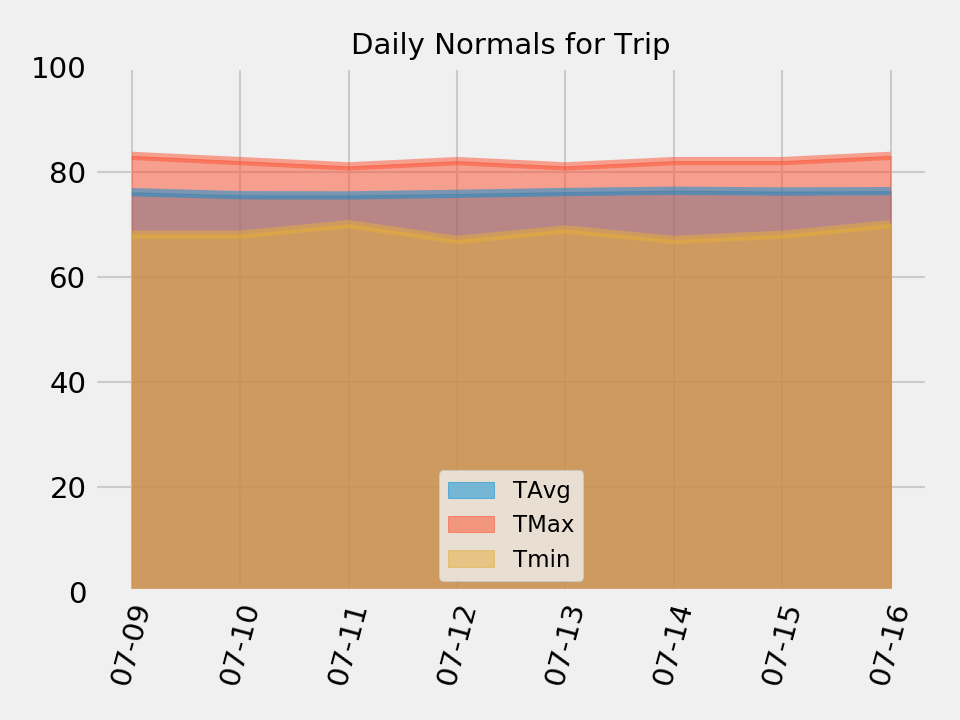

In [31]:
#Plot data into area plot
fig = normals_df.plot(kind = "area", stacked = False, ylim = (0,100), xticks = range(len(days)))
plt.title("Daily Normals for Trip", fontsize = 14)
plt.legend(loc = 8, fontsize = 11)
fig.set_xticklabels(days, rotation=75)
plt.tight_layout()
plt.show()